In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
7,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
5,2b59a61e-2810-49e3-b70c-402437ec871b,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_ill_conditioned
4,dc959354-120d-4691-ad8c-12984805176e,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_ill_conditioned_2
3,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
1,cd74c80b-c484-4595-85f0-0f435668bcb6,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_standard
2,pretrained_ill,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
0,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
6,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [3]:
task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

#run_id = "2b59a61e-2810-49e3-b70c-402437ec871b"  # if you train more models, replace with the run_id from the table above
run_id = "pretrained"
run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

linear_regression_pretrained pretrained


100%|██████████| 15/15 [00:00<00:00, 81075.46it/s]


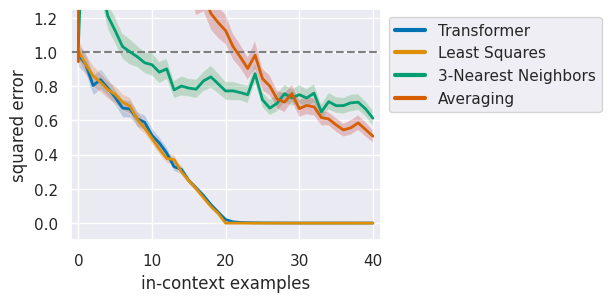

In [4]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

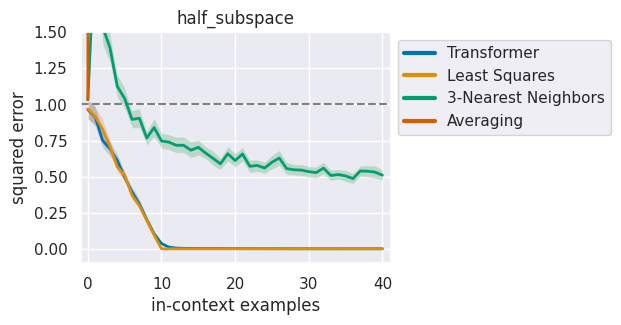

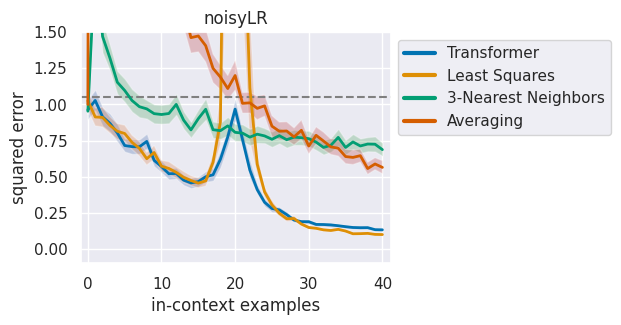

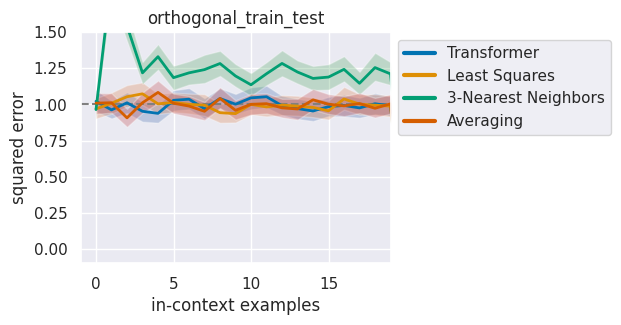

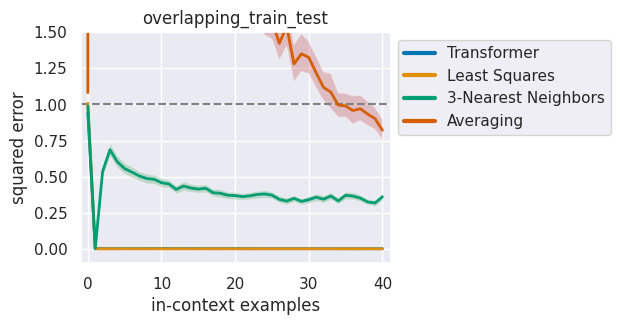

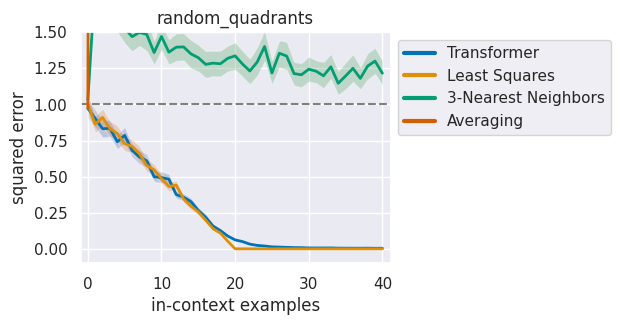

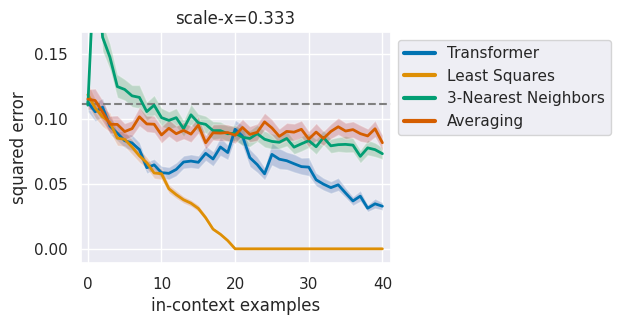

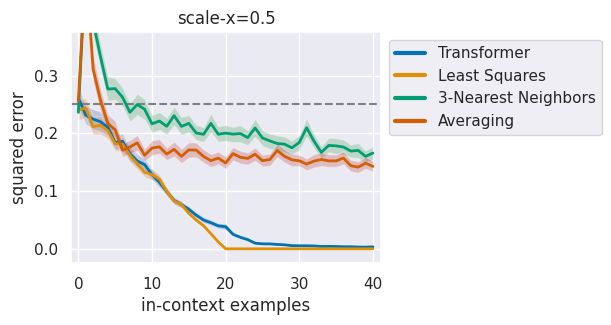

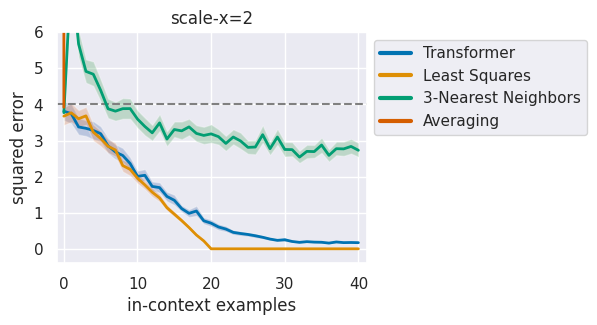

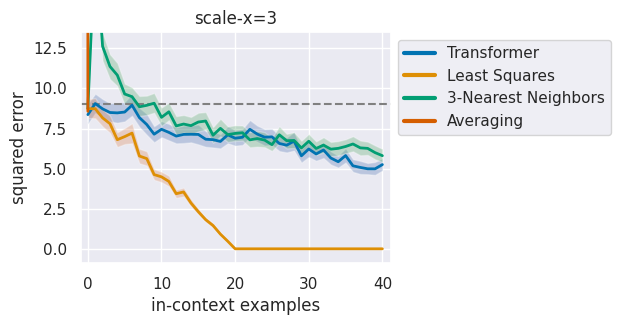

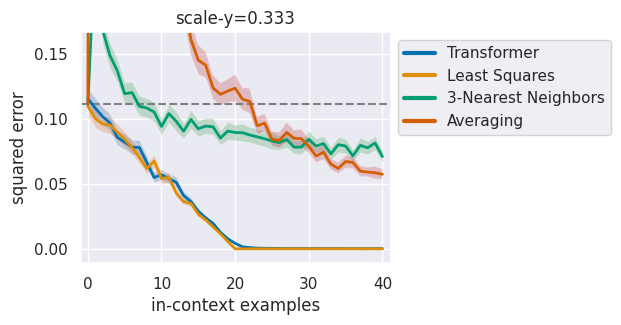

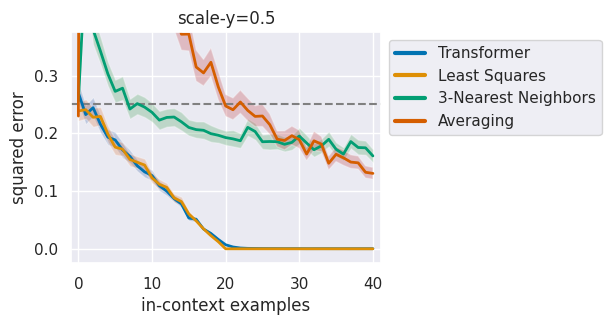

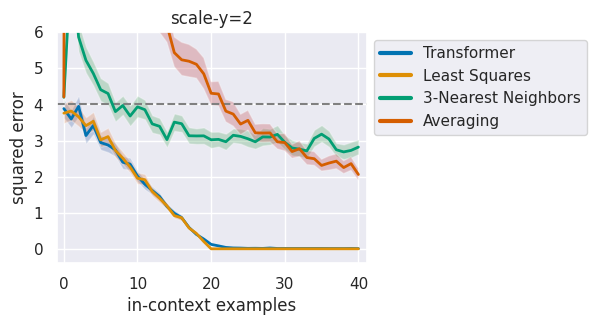

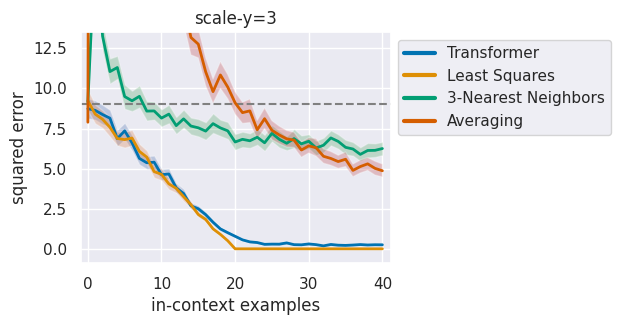

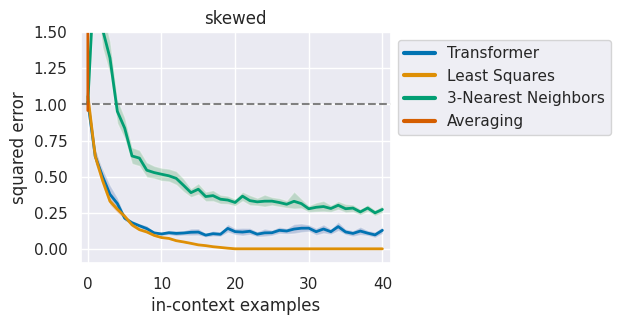

In [5]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [4]:
from samplers import get_data_sampler
from tasks import get_task_sampler
import models
from eval import eval_batch, aggregate_metrics

In [94]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler_ill = get_data_sampler('ill-conditioned', n_dims)
data_sampler_gau = get_data_sampler('gaussian', n_dims, scale=3*torch.eye(n_dims))
#data_sampler_gau = get_data_sampler('gaussian', n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs,
)

ill-conditioned
gaussian


In [95]:
task_sampler = get_task_sampler(
    'linear_regression',
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [96]:
task = task_sampler()
xs_gau = data_sampler_gau.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys_gau = task.evaluate(xs_gau)

xs_ill = data_sampler_ill.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end, kappa=20)
ys_ill = task.evaluate(xs_ill)

In [97]:
with torch.no_grad():
    pred_gau = model(xs_gau, ys_gau)
    pred_ill = model(xs_ill, ys_ill)

In [86]:
%autoreload

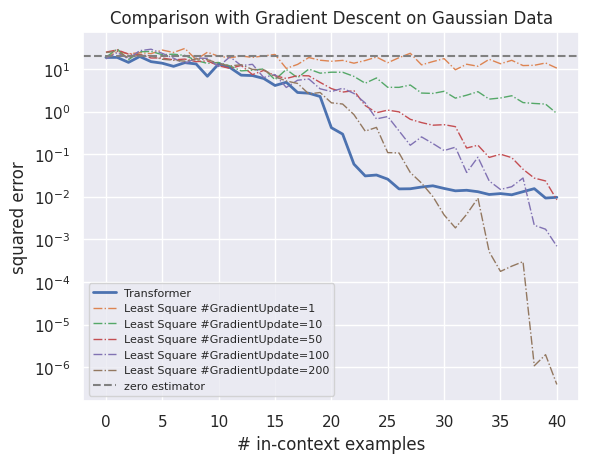

In [87]:
metric = task.get_metric()
loss_gau = metric(pred_gau, ys_gau).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss_gau.mean(axis=0), lw=2, label="Transformer")
for n_steps in [1, 10, 50, 100, 200]:
    lstsq_model = models.LeastSquaresModelGradientDescent(n_steps=n_steps, step_size=0.01)
    lstsq_gau = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs_gau))['mean']
    plt.plot(lstsq_gau, lw=1, ls="-.", label=f"Least Square #GradientUpdate={n_steps}")

plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.title("Comparison with Gradient Descent on Gaussian Data")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.yscale("log")
plt.legend(loc="lower left", fontsize=8)
plt.show()

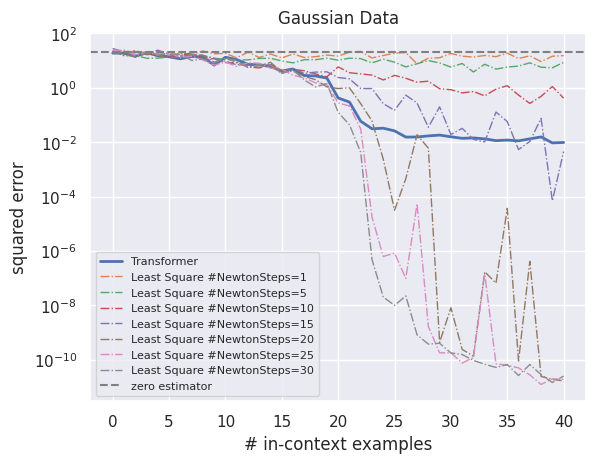

In [88]:
metric = task.get_metric()
loss_gau = metric(pred_gau, ys_gau).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss_gau.mean(axis=0), lw=2, label="Transformer")
for n_newton_steps in [1, 5, 10, 15, 20, 25, 30]:
    lstsq_model = models.LeastSquaresModelNewtonMethod(n_newton_steps=n_newton_steps)
    lstsq_gau = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs_gau))['mean']
    plt.plot(lstsq_gau, lw=1, ls="-.", label=f"Least Square #NewtonSteps={n_newton_steps}")

plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.title("Gaussian Data")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.yscale("log")
plt.legend(loc="lower left", fontsize=8)
plt.show()

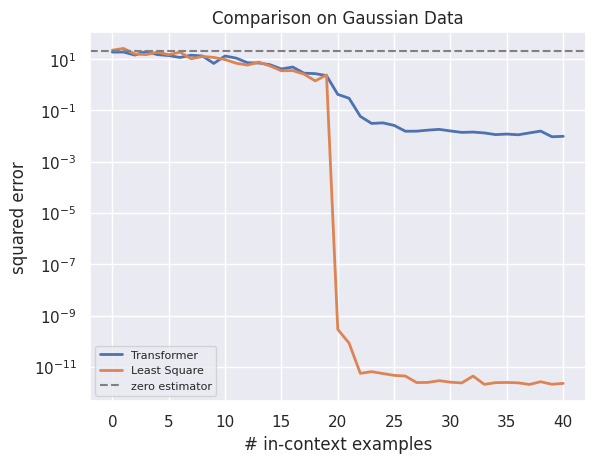

In [91]:
metric = task.get_metric()
loss_gau = metric(pred_gau, ys_gau).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss_gau.mean(axis=0), lw=2, label="Transformer")

lstsq_model = models.LeastSquaresModel()
lstsq_gau = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs_gau))['mean']
plt.plot(lstsq_gau, lw=2, label=f"Least Square")

plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.title("Comparison on Gaussian Data")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.yscale("log")
plt.legend(loc="best", fontsize=8)
plt.show()

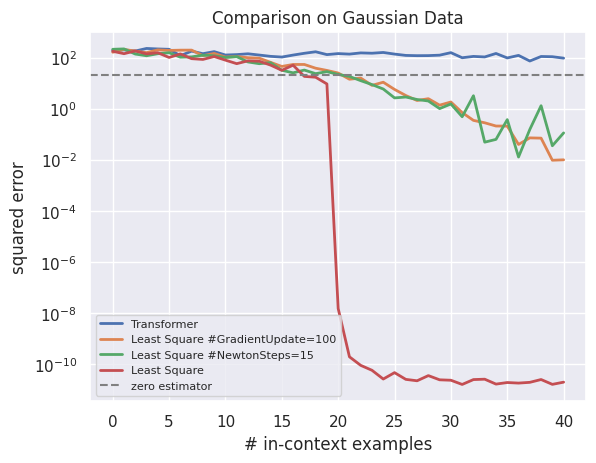

In [98]:
metric = task.get_metric()
loss_gau = metric(pred_gau, ys_gau).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss_gau.mean(axis=0), lw=2, label="Transformer")

lstsq_model = models.LeastSquaresModelGradientDescent(n_steps=100, step_size=0.001)
lstsq_gau = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs_gau))['mean']
plt.plot(lstsq_gau, lw=2, label=f"Least Square #GradientUpdate=100")

lstsq_model = models.LeastSquaresModelNewtonMethod(n_newton_steps=15)
lstsq_gau = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs_gau))['mean']
plt.plot(lstsq_gau, lw=2, label=f"Least Square #NewtonSteps=15")

lstsq_model = models.LeastSquaresModel()
lstsq_gau = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs_gau))['mean']
plt.plot(lstsq_gau, lw=2, label=f"Least Square")

plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.title("Comparison on Gaussian Data")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.yscale("log")
plt.legend(loc="lower left", fontsize=8)
plt.show()

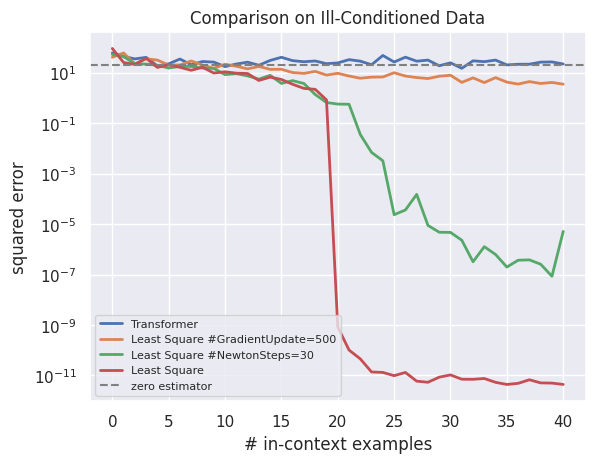

In [104]:
metric = task.get_metric()
loss_ill = metric(pred_ill, ys_ill).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss_ill.mean(axis=0), lw=2, label="Transformer")

lstsq_model = models.LeastSquaresModelGradientDescent(n_steps=500, step_size=0.0001)
lstsq_ill = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs_ill))['mean']
plt.plot(lstsq_ill, lw=2, label=f"Least Square #GradientUpdate=500")

lstsq_model = models.LeastSquaresModelNewtonMethod(n_newton_steps=30)
lstsq_ill = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs_ill))['mean']
plt.plot(lstsq_ill, lw=2, label=f"Least Square #NewtonSteps=30")

lstsq_model = models.LeastSquaresModel()
lstsq_ill = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs_ill))['mean']
plt.plot(lstsq_ill, lw=2, label=f"Least Square")

plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.title("Comparison on Ill-Conditioned Data")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.yscale("log")
plt.legend(loc="lower left", fontsize=8)
plt.show()

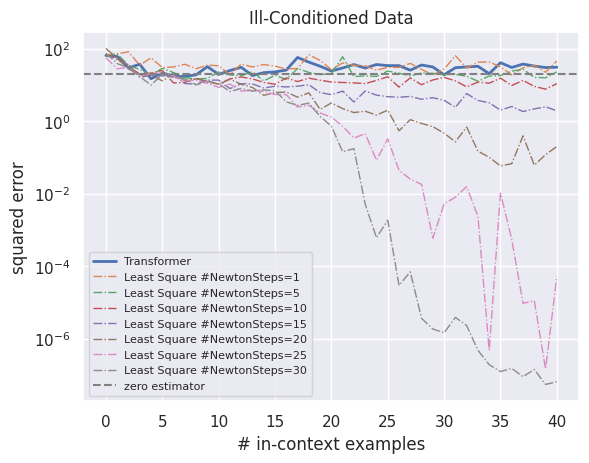

In [90]:
metric = task.get_metric()
loss_ill = metric(pred_ill, ys_ill).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss_ill.mean(axis=0), lw=2, label="Transformer")
for n_newton_steps in [1, 5, 10, 15, 20, 25, 30]:
    lstsq_model = models.LeastSquaresModelNewtonMethod(n_newton_steps=n_newton_steps)
    lstsq_ill = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs_ill))['mean']
    plt.plot(lstsq_ill, lw=1, ls="-.", label=f"Least Square #NewtonSteps={n_newton_steps}")

plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.title("Ill-Conditioned Data")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.yscale("log")
plt.legend(loc="lower left", fontsize=8)
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [86]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

NameError: name 'xs' is not defined

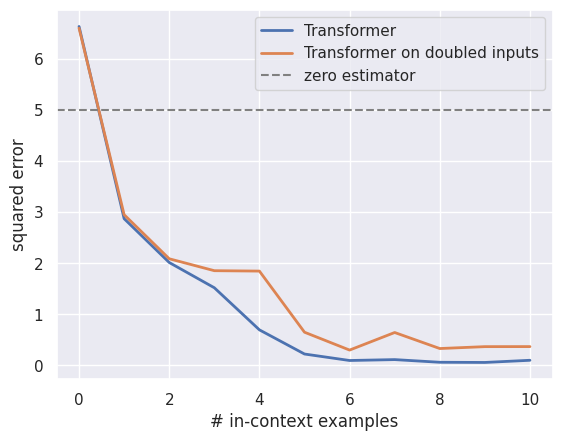

In [ ]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.